In [1]:
from fastai.vision.all import *
from fastaudio.all import *

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


In [2]:
path = Path('pitch_accent')

In [3]:
path

Path('pitch_accent')

In [4]:
labels = pd.read_csv(path / 'all_labeles.csv')
labels = labels[labels.pattern.isin(['頭高', '中高', '平板'])];

In [5]:
labels["is_valid"] = False

In [6]:
labels.loc[labels.type == "ojad male", "is_valid"] = True

In [7]:
labels

,path,pattern,kana,morae,drop,type,is_valid
0,accentAudio/ある.yomi000142BB_0596.mp3,頭高,アル,2,1,nhk,False
1,accentAudio/思う.yomi0006C617_043A.mp3,中高,オモウ,3,2,nhk,False
2,accentAudio/など.yomi000240B7_0028.mp3,頭高,ナド,2,1,nhk,False
3,accentAudio/私.yomi00092F63_0072.mp3,平板,ワタくシ,4,0,nhk,False
4,accentAudio/見る.yomi000A41BD_001E.mp3,頭高,ミル,2,1,nhk,False
...,...,...,...,...,...,...,...
163962,OjadMedia/立て-377_10_1_female.mp3,頭高,たて,2,1,ojad female,False
163963,OjadMedia/立てる-377_11_1_male.mp3,中高,たてる,3,2,ojad male,True
163964,OjadMedia/立てる-377_11_1_female.mp3,中高,たてる,3,2,ojad female,False
163965,OjadMedia/立とう-377_12_1_male.mp3,中高,たとう,3,2,ojad male,True


In [8]:
labels.pattern.replace(['頭高', '中高', '平板'], ['atamadaka', 'nakadaka', 'heiban'], inplace=True)

In [9]:
pitch_cfg = AudioConfig.Voice(f_min=0, f_max=8000, n_fft=1024*2, win_length=1024, n_mels=64)

In [ ]:
aud2spec = AudioToSpec.from_cfg(pitch_cfg)

In [11]:
item_tfms = [RemoveSilence(),ResizeSignal(2000)]#, aud2spec]

In [12]:
def get_x(df):
    return df.path
def get_y(df):
    return df.pattern

In [10]:
labels.path = path / labels.path

In [11]:
labels

,path,pattern,kana,morae,drop,type,is_valid
0,pitch_accent/accentAudio/ある.yomi000142BB_0596.mp3,atamadaka,アル,2,1,nhk,False
1,pitch_accent/accentAudio/思う.yomi0006C617_043A.mp3,nakadaka,オモウ,3,2,nhk,False
2,pitch_accent/accentAudio/など.yomi000240B7_0028.mp3,atamadaka,ナド,2,1,nhk,False
3,pitch_accent/accentAudio/私.yomi00092F63_0072.mp3,heiban,ワタくシ,4,0,nhk,False
4,pitch_accent/accentAudio/見る.yomi000A41BD_001E.mp3,atamadaka,ミル,2,1,nhk,False
...,...,...,...,...,...,...,...
163962,pitch_accent/OjadMedia/立て-377_10_1_female.mp3,atamadaka,たて,2,1,ojad female,False
163963,pitch_accent/OjadMedia/立てる-377_11_1_male.mp3,nakadaka,たてる,3,2,ojad male,True
163964,pitch_accent/OjadMedia/立てる-377_11_1_female.mp3,nakadaka,たてる,3,2,ojad female,False
163965,pitch_accent/OjadMedia/立とう-377_12_1_male.mp3,nakadaka,たとう,3,2,ojad male,True


In [12]:
labels.to_csv("training.csv")

In [15]:
dblock = DataBlock(blocks=[AudioBlock, CategoryBlock],
                  item_tfms=item_tfms,
                  batch_tfms=[aud2spec],
                  get_x=get_x,
                  get_y=get_y,
                  splitter=ColSplitter())

In [16]:
dls = dblock.dataloaders(labels, shuffle=True, bs=128)

In [32]:
save_pickle('pitch_dls', dls)

In [17]:
def show_spec_batch(dls):
    _,axes = plt.subplots(3,3, figsize=(12,8))
    for (spec, pattern),ax in zip(dls.show_batch(show=False)[2], axes.flatten()):
        show_image(spec, title=pattern, ax=ax).invert_yaxis()

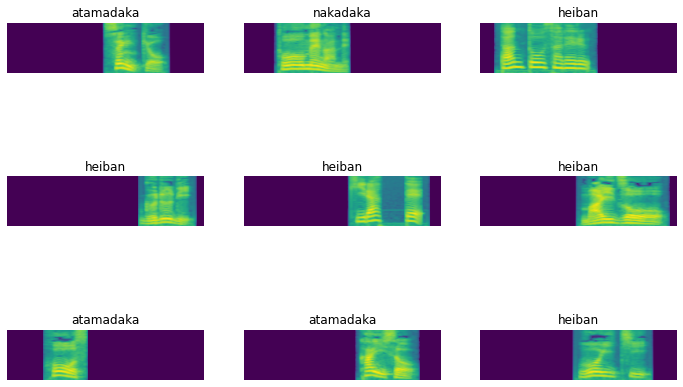

In [18]:
show_spec_batch(dls)

In [19]:
class Model(Module):
    
    def __init__(self, input_dim, hidden_size, output_size):
        
        self.rnn = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, batch_first=True)
        self.head = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        
        output, _ = self.rnn(x.transpose(-1,-2).squeeze())
        return self.head(output[:,-1])

In [20]:
x = dls.one_batch()[0]

In [21]:
input_dim = x.shape[2]

In [31]:
model = Model(input_dim = input_dim, hidden_size = input_dim*2, output_size=3).cuda()

In [30]:
import wandb
from fastai.callback.wandb import *
run = wandb.init(project='LSTM pitch')

In [24]:
WANDB_NOTEBOOK_NAME = 'pitch LSTM'

In [32]:
learn = Learner(dls, model, metrics = [accuracy, F1Score(average='weighted')],
                cbs=[WandbCallback(log='all'), SaveModelCallback()])

SuggestedLRs(valley=0.0003981071640737355)

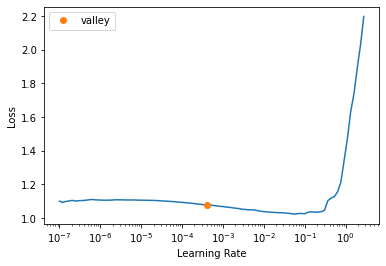

In [26]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.395985,0.464836,0.842124,0.804415,08:03


WandbCallback was not able to get prediction samples -> wandb.log must be passed a dictionary
Better model found at epoch 0 with valid_loss value: 0.4648357629776001.


In [36]:
log_model("models/model.pth")

In [37]:
log_dataset("pitch_accent")

wandb: Adding directory to artifact (/home/studio-lab-user/pitch_accent/accentAudio)... Done. 13.5s
wandb: Adding directory to artifact (/home/studio-lab-user/pitch_accent/OjadMedia)... Done. 14.2s
wandb: Adding directory to artifact (/home/studio-lab-user/pitch_accent/.ipynb_checkpoints)... Done. 0.0s


In [40]:
run.finish()

accuracy,█▁▂▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_score,▆▁██
lr_0,▁▁▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,██▇▆▆▅▄▄▃▃▃▄▃▂▂▃▃▃▂▂▂▃▂▁▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▇▆▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▂█▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
